In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import holidays
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
pd.set_option('display.max_columns',60)
import warnings
warnings.filterwarnings('ignore')

## Step 1: Define Helper Functions

In [2]:
csv_files_2017 = [('2017' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files_2018 = [('2018' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files_2019 = [('2019' + "%.2d" + '-citibike-tripdata.csv') % i for i in range(1, 13)]
csv_files = csv_files_2017 + csv_files_2018 + csv_files_2019

In [3]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [4]:
def time_parser(df):
    """
    This function is to convert starttime and stoptime to datetime format. 
    Add some time related features such as date, year, month, hour, day of a week, Is weekday or not, Is NY holidays or not. 
    
    Input: a data frame
    
    Output: a new data frame with added date time features

    """
    df1 = df.copy()
    df1['starttime'] = pd.to_datetime(df1['starttime'])
    df1['stoptime'] = pd.to_datetime(df1['stoptime'])
    df1['start_date'] = df1['starttime'].dt.date
    df1['start_year'] = df1['starttime'].dt.year
    df1['start_month'] = df1['starttime'].dt.month
    df1['start_day'] = df1['starttime'].dt.day
    df1['start_hour'] = df1['starttime'].dt.hour
    df1['start_dayofweek'] = df1['starttime'].dt.weekday+1   # Monday is 1, Sunday is 7
    df1['Isweekday'] = [0 if 6<=x<=7 else 1 for x in df1['start_dayofweek']]
    NYholidays = holidays.UnitedStates(state = 'NY')
    df1['holidays'] = list(map(lambda x: x in NYholidays, df1.start_date)) 
    df1['holidays'] = df1['holidays'].map({True:1,False:0})
    df1['stop_date'] = df1['stoptime'].dt.date
    df1['stop_hour'] = df1['stoptime'].dt.hour
    mask = df1['start_hour'].apply(lambda x: 5 <= x <= 22) # Remove offpeak hours(from 10pm-5am)
    return df1[mask]


In [5]:
def aggregated_data(df):
    """
    This function is to add some aggregated features such as distance, and hourly trip information. 
    
    Input: a data frame
    
    Output: a new data frame with added features
    """
    # Define distance: if same start and end location, use average speed of 7.456mph to estimate distance.
    # If different locations, calculate Manhattan distance between two stations
    df['distance']=np.where(df['start_station_ID'] == df['end_station_ID'],df['trip_duration']*7.456/3600,
                            abs(df['start_station_longitude']-df['end_station_longitude'])*53+\
                            abs(df['start_station_latitude']-df['end_station_latitude'])*69)
    # Daily average of all stations for time-series analysis
    df_daily = df.groupby('start_date').agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_daily.columns = ['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']
    df_daily_merged = df.merge(df_daily, how = 'left', on = 'start_date')
    # Hourly average for each station regardeless of days 
    df_hourly = df.groupby(['start_station_ID','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly.columns = ['start_station_ID','start_hour','trip_per_hour','hourly_avg_trip_duration','hourly_avg_distance']
    df_hourly_merged = df_daily_merged.merge(df_hourly, how = 'left', on = ['start_station_ID','start_hour'])
    # Calculate hourly trip counts, avg trip duration, and avg trip distance per station and merge to above df
    df_hourly_eachday = df.groupby(['start_station_ID','start_date','start_hour']).\
    agg({'trip_duration':['count','mean'],'distance':'mean'}).reset_index()
    df_hourly_eachday.columns = ['start_station_ID','start_date','start_hour','trip_per_hour_eachday',
                                 'hourly_avg_trip_duration_eachday','hourly_avg_distance_eachday']
    df_hourly_eachday_merged = df_hourly_merged.merge(df_hourly_eachday, how = 'left',
                                                      on = ['start_station_ID','start_date','start_hour'])
    return df_hourly_eachday_merged    

In [6]:
def merge_bikecount(df):
    """
    This method is used to add aggregated features such as hourly checkin and checkout counts for each station.
    
    Input: a dataframe
    
    Output: a new dataframe with added features
    """
    # groupby start station ID, date and hour to get hourly counts of trips per start station
    checkout = df.groupby(['start_station_ID','start_date','start_hour'])['trip_duration'].count().reset_index()
    checkout.columns = ['start_station_ID','start_date','start_hour','checkout_counts']
    # groupby end station ID, date, and hour to get hourly counts of trips per end station 
    checkin = df.groupby(['end_station_ID','stop_date','stop_hour'])[['trip_duration']].count().reset_index()
    checkin.columns=['end_station_ID','stop_date','stop_hour','checkin_counts']
    # Join dataframe to get station checkin and checkout counts 
    temp = pd.merge(checkout, checkin,  how='outer', left_on=['start_station_ID','start_date','start_hour'], 
                    right_on = ['end_station_ID','stop_date','stop_hour'])
    temp['start_station_ID'] = temp['start_station_ID'].fillna(temp['end_station_ID'])
    temp['start_date'] = temp['start_date'].fillna(temp['stop_date'])
    temp['start_hour'] = temp['start_hour'].fillna(temp['stop_hour'])
    temp['checkout_counts'] = temp['checkout_counts'].fillna(0)
    temp['checkin_counts'] = temp['checkin_counts'].fillna(0)
    temp = temp.drop(['end_station_ID','stop_date','stop_hour'],axis=1)
    temp.columns=['station_ID','date','hour','checkout_counts','checkin_counts']
    temp['total_counts'] = temp['checkin_counts'] + temp['checkout_counts']
    # merge orginal dataframe to get hourly checkin/checkout information for both start and stop stations 
    df_temp_merged = pd.merge(df, temp,  how='left', left_on=['start_station_ID','start_date','start_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1)
    df_temp_merged = pd.merge(df_temp_merged, temp,  how='left', left_on=['end_station_ID','stop_date','stop_hour'], 
         right_on = ['station_ID','date','hour']).drop(['station_ID','date','hour'],axis = 1) 
    df_temp_merged = df_temp_merged.rename(columns={'checkout_counts_x':'start_station_checkout_counts',
                                                    'checkin_counts_x':'start_station_checkin_counts',
                                                    'total_counts_x':'start_station_total_counts', 
                                                    'checkout_counts_y':'end_station_checkout_counts',
                                                    'checkin_counts_y':'end_station_checkin_counts',
                                                    'total_counts_y':'end_station_total_counts'}) 
    return df_temp_merged
    

## Step 2: Merge Monthly Datasets

In [7]:
# Read monthly Citi Bike trip data, apply some filters.
# Randomly select 5% of each month trip data and save it as csv for each month. 
# Similar method used to make test data for machine learning validation. 
total_time = 0
random.seed(0)
path = '../Tripdata/'
for i, csv in enumerate(csv_files):
    start_time = time.time()
    df_temp = pd.read_csv(path+csv)
    df_temp.columns = ['trip_duration','starttime','stoptime','start_station_ID','start_station_name',
                       'start_station_latitude','start_station_longitude','end_station_ID','end_station_name',
                       'end_station_latitude','end_station_longitude','bike_ID','user_type','birth_year','gender']
    # remove trips that are longer than 1 day 
    df_temp = df_temp.loc[df_temp['trip_duration']<= 24*3600]
    # remove areas that are not in NYC (equator and montreal)
    df_temp = df_temp.loc[(df_temp['start_station_latitude']>40) & (df_temp['start_station_latitude']<41)] 
    df_temp = df_temp.loc[(df_temp['end_station_latitude']>40) & (df_temp['end_station_latitude']<41)] 
    # add custom features using self-defined functions
    df_temp = time_parser(df_temp)
    df_temp = merge_bikecount(df_temp)
    df_temp = aggregated_data(df_temp)
    
    # take a 5% subset of monthly file for analysis and another 5% of the remaining dataset as test dataset for ML
    rows = len(df_temp)
    size = int(rows/20)
    random.seed(0)
    selected_idx = random.sample(range(1,rows), size)
    skip_idx = list(set(df_temp.index)-set(selected_idx))
    test_idx = random.sample(skip_idx,int(len(skip_idx)/20))
    df_train = df_temp.iloc[selected_idx,:].drop(['user_type','birth_year','gender'],axis=1)
    df_test = df_temp.iloc[test_idx,:].drop(['user_type','birth_year','gender'],axis=1)
 
    # save train and test datset 
    df_train.to_csv(months[i%12] + csv[:4] + 'train.csv')
    df_test.to_csv(months[i%12] + csv[:4] + 'test.csv')
    print('Finishing data extraction from ' + csv)
    timeSpent = time.time() - start_time
    print('This iteration uses %.2f'%(timeSpent))
    total_time += timeSpent
print(total_time)

Finishing data extraction from 201701-citibike-tripdata.csv
This iteration uses 14.08
Finishing data extraction from 201702-citibike-tripdata.csv
This iteration uses 15.79
Finishing data extraction from 201703-citibike-tripdata.csv
This iteration uses 15.03
Finishing data extraction from 201704-citibike-tripdata.csv
This iteration uses 27.78
Finishing data extraction from 201705-citibike-tripdata.csv
This iteration uses 35.22
Finishing data extraction from 201706-citibike-tripdata.csv
This iteration uses 40.49
Finishing data extraction from 201707-citibike-tripdata.csv
This iteration uses 41.07
Finishing data extraction from 201708-citibike-tripdata.csv
This iteration uses 40.69
Finishing data extraction from 201709-citibike-tripdata.csv
This iteration uses 40.66
Finishing data extraction from 201710-citibike-tripdata.csv
This iteration uses 42.04
Finishing data extraction from 201711-citibike-tripdata.csv
This iteration uses 33.58
Finishing data extraction from 201712-citibike-tripdat

In [8]:
train_list = []
test_list = []
for i, csv in enumerate(csv_files):
    train_list.append(months[i%12] + csv[:4] + 'train.csv')
    test_list.append(months[i%12] + csv[:4] + 'test.csv')

In [9]:
# Merge all months train.csv into one train dataframe
train_df = pd.DataFrame()
for i in range(len(train_list)):
    temp_df = pd.read_csv(train_list[i], index_col = 0)
    train_df = pd.concat([train_df, temp_df], axis = 0)
    print('Finished ' + str(i) + ' element')
#train_df.to_csv('train.csv')

Finished 0 element
Finished 1 element
Finished 2 element
Finished 3 element
Finished 4 element
Finished 5 element
Finished 6 element
Finished 7 element
Finished 8 element
Finished 9 element
Finished 10 element
Finished 11 element
Finished 12 element
Finished 13 element
Finished 14 element
Finished 15 element
Finished 16 element
Finished 17 element
Finished 18 element
Finished 19 element
Finished 20 element
Finished 21 element
Finished 22 element
Finished 23 element
Finished 24 element
Finished 25 element
Finished 26 element
Finished 27 element
Finished 28 element
Finished 29 element
Finished 30 element
Finished 31 element
Finished 32 element
Finished 33 element
Finished 34 element
Finished 35 element


In [10]:
#Merge all months test.csv into one test dataframe
test_df = pd.DataFrame()
for i in range(len(test_list)):
    temp_df = pd.read_csv(test_list[i], index_col = 0)
    test_df = pd.concat([test_df, temp_df], axis = 0)
    print('Finished ' + str(i) + ' element')
#test_df.to_csv('test.csv')

Finished 0 element
Finished 1 element
Finished 2 element
Finished 3 element
Finished 4 element
Finished 5 element
Finished 6 element
Finished 7 element
Finished 8 element
Finished 9 element
Finished 10 element
Finished 11 element
Finished 12 element
Finished 13 element
Finished 14 element
Finished 15 element
Finished 16 element
Finished 17 element
Finished 18 element
Finished 19 element
Finished 20 element
Finished 21 element
Finished 22 element
Finished 23 element
Finished 24 element
Finished 25 element
Finished 26 element
Finished 27 element
Finished 28 element
Finished 29 element
Finished 30 element
Finished 31 element
Finished 32 element
Finished 33 element
Finished 34 element
Finished 35 element


## Step 3: Merge other Datasets

### Weather Dataset

In [11]:
# Read weather data and create custom features.
weather = pd.read_csv('weather.csv',index_col = 0).reset_index()
weather = weather.fillna(0)
weather['DATE'] = pd.to_datetime(weather['DATE'])
weather['TAVG'] = (weather['TMIN']+weather['TMAX'])/2
weather['HasPRCP'] = [1 if x !=0 else 0 for x in weather['PRCP']]
weather['HasSNOW'] = [1 if x !=0 else 0 for x in weather['SNOW']]

In [12]:
# Merge weather info with train data
train_df['start_date'] = pd.to_datetime(train_df['start_date'])
train_df_weather = train_df.merge(weather,how='left',
                                  left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

In [13]:
# Merge weather info with test data
test_df['start_date'] = pd.to_datetime(test_df['start_date'])
test_df_weather = test_df.merge(weather,how='left',
                                  left_on = 'start_date', right_on = 'DATE').drop(['DATE'],axis=1)

### Bike Dataset

In [14]:
# Read dock capacity data by month
bike_files_2017 = [('bikeshare_nyc_raw_2017'+'%.2d'+'.csv') % i for i in range(1, 13)]
bike_files_2018 = [('bikeshare_nyc_raw_2018'+'%.2d'+'.csv') % i for i in range(1, 13)]
bike_files_2019 = [('bikeshare_nyc_raw_2019'+'%.2d'+'.csv') % i for i in range(1, 5)]
bike_files = bike_files_2017 + bike_files_2018 + bike_files_2019

In [15]:
# Merge all months data 
dock_df = pd.DataFrame()
for i in bike_files: 
    bike_temp = pd.read_csv(i,sep='\t',usecols=['dock_id', 'dock_name', "date", "tot_docks"])
    dock_df = pd.concat([dock_df,bike_temp],axis = 0)
    print('Finished %s'%i)

Finished bikeshare_nyc_raw_201701.csv
Finished bikeshare_nyc_raw_201702.csv
Finished bikeshare_nyc_raw_201703.csv
Finished bikeshare_nyc_raw_201704.csv
Finished bikeshare_nyc_raw_201705.csv
Finished bikeshare_nyc_raw_201706.csv
Finished bikeshare_nyc_raw_201707.csv
Finished bikeshare_nyc_raw_201708.csv
Finished bikeshare_nyc_raw_201709.csv
Finished bikeshare_nyc_raw_201710.csv
Finished bikeshare_nyc_raw_201711.csv
Finished bikeshare_nyc_raw_201712.csv
Finished bikeshare_nyc_raw_201801.csv
Finished bikeshare_nyc_raw_201802.csv
Finished bikeshare_nyc_raw_201803.csv
Finished bikeshare_nyc_raw_201804.csv
Finished bikeshare_nyc_raw_201805.csv
Finished bikeshare_nyc_raw_201806.csv
Finished bikeshare_nyc_raw_201807.csv
Finished bikeshare_nyc_raw_201808.csv
Finished bikeshare_nyc_raw_201809.csv
Finished bikeshare_nyc_raw_201810.csv
Finished bikeshare_nyc_raw_201811.csv
Finished bikeshare_nyc_raw_201812.csv
Finished bikeshare_nyc_raw_201901.csv
Finished bikeshare_nyc_raw_201902.csv
Finished bik

In [16]:
dock_df['date']=pd.to_datetime(dock_df['date'])
dockdf = dock_df.groupby(['dock_name','date'])['tot_docks'].agg({'first'}).reset_index()
dockdf.columns=['start_station_name','start_date','tot_docks']
dockdf['start_date']=pd.to_datetime(dockdf['start_date'])
mask = (dockdf['start_date']>='2017-01-01 00:00:00') & (dockdf['start_date']<'2019-05-01 00:00:00') 
# remove any dates that are non-relevent 
dockdf=dockdf.loc[mask]

In [17]:
station_list = list(dockdf['start_station_name'].unique())
date_list = list(pd.date_range(start='1/1/2017', end='12/31/2019').date)

In [18]:
station_date = pd.DataFrame(list(product(station_list, date_list)), columns=['start_station_name', 'start_date'])
station_date['start_date'] = pd.to_datetime(station_date['start_date'])

In [19]:
station_capacity = station_date.merge(dockdf,how='left',on=['start_station_name','start_date'])
station_capacity['start_year'] = station_capacity['start_date'].dt.year
station_capacity['start_month'] = station_capacity['start_date'].dt.month

In [20]:
groupby_df = station_capacity.groupby(['start_station_name','start_year'])['tot_docks'].agg({'median'}).reset_index()
station_capacity = station_capacity.merge(groupby_df,how ='left',on=['start_station_name','start_year'])

In [21]:
mask = (station_capacity['tot_docks'] < (station_capacity['median'] - 10)) & (station_capacity['tot_docks']<10)
station_capacity['tot_docks'][mask] = station_capacity['median']

In [22]:
station_capacity['tot_docks'] = station_capacity.groupby(['start_station_name','start_year'])['tot_docks'].\
transform(lambda x: x.fillna(x.median()))

In [23]:
station_capacity.drop(['start_year','start_month'],axis=1,inplace=True)

In [24]:
# station_capacity.to_csv('total_docks.csv')

In [25]:
dockdf = pd.read_csv('total_docks.csv',index_col = 0)
dockdf['start_date']=pd.to_datetime(dockdf['start_date'])

In [26]:
dockdf_merged_train = train_df_weather.merge(dockdf,how='left',on=['start_station_name','start_date'])
dockdf_merged_train.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,2017-01-19,2017,1,19,18,4,1,0,2017-01-19,18,92.0,72.0,164.0,4.0,12.0,16.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.0,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,61.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,2017-01-21,2017,1,21,11,6,0,0,2017-01-21,11,7.0,16.0,23.0,5.0,9.0,14.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.0,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,39.0,39.0
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,2017-01-04,2017,1,4,8,3,1,0,2017-01-04,8,17.0,3.0,20.0,6.0,5.0,11.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.0,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,37.0,37.0
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,2017-01-13,2017,1,13,20,5,1,0,2017-01-13,20,6.0,4.0,10.0,1.0,2.0,3.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.0,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,35.0,35.0
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,2017-01-25,2017,1,25,18,3,1,0,2017-01-25,18,8.0,3.0,11.0,6.0,6.0,12.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.0,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,39.0,39.0


In [27]:
dock_station = pd.read_csv('dock_station.csv',usecols=['start_station_name','capacity'])
dock_station.head()

,start_station_name,capacity
0,Broadway & E 22 St,39
1,8 Ave & W 31 St,19
2,W 52 St & 11 Ave,55
3,Franklin St & W Broadway,33
4,St James Pl & Pearl St,27


### Merge Dockstation with train dataset

In [28]:
dock_station_train_merged = dockdf_merged_train.merge(dock_station,how='left',on=['start_station_name'])
print(dock_station_train_merged.tot_docks.isna().sum())
mask1 = (dock_station_train_merged['tot_docks']<=10) & (dock_station_train_merged['capacity']>20)
dock_station_train_merged.tot_docks[mask1] = np.nan
print(dock_station_train_merged.tot_docks.isna().sum())
dock_station_train_merged['tot_docks'] = dock_station_train_merged['tot_docks'].fillna(dock_station_train_merged['capacity'])
dock_station_train_merged.tot_docks.isna().sum()
# drop capacity column
# dock_station_merged.drop(['capacity'],axis=1)

176549
176983


27492

In [29]:
dock_station_train_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,2017-01-19,2017,1,19,18,4,1,0,2017-01-19,18,92.0,72.0,164.0,4.0,12.0,16.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.0,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,61.0,69.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,2017-01-21,2017,1,21,11,6,0,0,2017-01-21,11,7.0,16.0,23.0,5.0,9.0,14.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.0,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,39.0,39.0,50.0
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,2017-01-04,2017,1,4,8,3,1,0,2017-01-04,8,17.0,3.0,20.0,6.0,5.0,11.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.0,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,37.0,37.0,58.0
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,2017-01-13,2017,1,13,20,5,1,0,2017-01-13,20,6.0,4.0,10.0,1.0,2.0,3.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.0,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,35.0,35.0,34.0
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,2017-01-25,2017,1,25,18,3,1,0,2017-01-25,18,8.0,3.0,11.0,6.0,6.0,12.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.0,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,39.0,39.0,56.0


In [30]:
# Impute missing values in tot_docks for all stations
missing = list(dock_station_train_merged.loc[dock_station_train_merged.tot_docks.isna()]['start_station_ID'].unique())
for i in missing:
    missingrows = len(dock_station_train_merged.loc[(dock_station_train_merged['start_station_ID']==i)\
                                                    & (dock_station_train_merged['tot_docks'].isna())])
    if len(dock_station_train_merged.loc[(dock_station_train_merged['start_station_ID']==i)]) != missingrows:
        mask =  (dock_station_train_merged['start_station_ID']==i) & (dock_station_train_merged['tot_docks'].isna())
        med = dock_station_train_merged.loc[(dock_station_train_merged['start_station_ID']==i)]['tot_docks'].median()
        dock_station_train_merged.loc[mask,'tot_docks']=dock_station_train_merged.loc[mask,'tot_docks'].fillna(med) 
dock_station_train_merged.loc[dock_station_train_merged.tot_docks.isna()]['start_station_ID'].nunique()

47

In [31]:
# Name is not matching or station is obselete 
missing1 = list(dock_station_train_merged.loc[dock_station_train_merged.tot_docks.isna()]['start_station_ID'].unique())
dock_station_train_merged.loc[dock_station_train_merged['start_station_ID'].isin(missing1)]

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity
667,337,2017-01-11 18:37:54,2017-01-11 18:43:32,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,295.0,Pike St & E Broadway,40.714067,-73.992939,17596,2017-01-11,2017,1,11,18,3,1,0,2017-01-11,18,4.0,8.0,12.0,4.0,5.0,9.0,0.909529,32036,712.750936,1.415919,54.0,470.925926,0.913873,4.0,622.000000,1.423738,5.82,0.52,0.0,0.0,52,42,1.0,0.0,0.0,0.0,0.0,0.0,47.0,1,0,NaN,NaN,NaN
729,314,2017-01-26 11:29:17,2017-01-26 11:34:31,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,303.0,Mercer St & Spring St,40.723627,-73.999496,15350,2017-01-26,2017,1,26,11,4,1,0,2017-01-26,11,3.0,1.0,4.0,2.0,3.0,5.0,0.597356,32084,685.643872,1.364001,53.0,685.509434,1.335296,3.0,543.333333,1.157725,6.71,0.02,0.0,0.0,56,43,0.0,0.0,0.0,0.0,0.0,0.0,49.5,1,0,NaN,NaN,NaN
2218,1897,2017-01-06 17:27:53,2017-01-06 17:59:31,255.0,NYCBS Depot - SSP,40.646768,-74.016510,467.0,Dean St & 4 Ave,40.683125,-73.978951,25326,2017-01-06,2017,1,6,17,5,1,0,2017-01-06,17,2.0,0.0,2.0,3.0,4.0,7.0,4.499233,23575,660.306596,1.284048,10.0,2669.500000,6.378892,2.0,2397.500000,5.292108,4.70,0.05,1.2,1.2,33,25,1.0,0.0,0.0,0.0,0.0,1.0,29.0,1,1,NaN,NaN,NaN
3023,238,2017-01-17 06:48:32,2017-01-17 06:52:30,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,251.0,Mott St & Prince St,40.723180,-73.994800,19047,2017-01-17,2017,1,17,6,2,1,0,2017-01-17,6,3.0,1.0,4.0,0.0,1.0,1.0,0.379372,18190,661.653161,1.369798,25.0,539.920000,1.089815,3.0,315.000000,0.526011,4.92,0.35,0.0,0.0,42,38,1.0,0.0,0.0,0.0,0.0,1.0,40.0,1,0,NaN,NaN,NaN
3107,642,2017-01-06 19:42:22,2017-01-06 19:53:04,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,2009.0,Catherine St & Monroe St,40.711174,-73.996826,21481,2017-01-06,2017,1,6,19,5,1,0,2017-01-06,19,2.0,1.0,3.0,0.0,2.0,2.0,1.315108,23575,660.306596,1.284048,67.0,602.462687,1.199091,2.0,489.000000,1.064804,4.70,0.05,1.2,1.2,33,25,1.0,0.0,0.0,0.0,0.0,1.0,29.0,1,1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2624949,227,2019-12-07 17:49:20.119,2019-12-07 17:53:07.856,3788.0,E 12 St & 4 Av,40.732690,-73.989740,335.0,Washington Pl & Broadway,40.729039,-73.994046,20682,2019-12-07,2019,12,7,17,6,0,0,2019-12-07,17,7.0,5.0,12.0,10.0,7.0,17.0,0.480151,32371,754.944549,1.280923,222.0,577.103604,1.023719,7.0,356.285714,0.744809,6.93,0.00,0.0,0.0,38,30,0.0,0.0,0.0,0.0,0.0,0.0,34.0,0,0,NaN,NaN,NaN
2624995,263,2019-12-23 09:47:43.246,2019-12-23 09:52:07.205,3788.0,E 12 St & 4 Av,40.732690,-73.989740,402.0,Broadway & E 22 St,40.740343,-73.989551,29564,2019-12-23,2019,12,23,9,1,1,0,2019-12-23,9,5.0,6.0,11.0,5.0,34.0,39.0,0.538083,36339,749.207766,1.315911,150.0,660.486667,1.135670,5.0,361.000000,0.841050,4.70,0.00,0.0,0.0,57,41,0.0,0.0,0.0,0.0,0.0,0.0,49.0,0,0,NaN,NaN,NaN
2625221,1217,2019-12-06 09:00:24.315,2019-12-06 09:20:41.757,3788.0,E 12 St & 4 Av,40.732690,-73.989740,3749.0,Lexington Ave & E 36 St,40.747574,-73.978801,34391,2019-12-06,2019,12,6,9,5,1,0,2019-12-06,9,15.0,9.0,24.0,6.0,6.0,12.0,1.606772,49943,717.196524,1.345852,150.0,660.486667,1.135670,15.0,801.733333,1.277325,7.38,0.00,0.0,0.0,50,34,0.0,0.0,0.0,0.0,0.0,0.0,4

In [32]:
# Sanity check and overwrite errors in dock capacity 
mask = dock_station_train_merged['tot_docks']!=0 
dock_station_train_merged = dock_station_train_merged[mask] # remove stations that have 0 tot_docks

In [33]:
dock_station_train_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity
0,538,2017-01-19 18:46:58,2017-01-19 18:55:56,519.0,Pershing Square North,40.751873,-73.977706,515.0,W 43 St & 10 Ave,40.760094,-73.994618,16671,2017-01-19,2017,1,19,18,4,1,0,2017-01-19,18,92.0,72.0,164.0,4.0,12.0,16.0,1.463633,35672,708.974658,1.420254,1147.0,764.414124,1.556025,92.0,740.130435,1.490564,3.58,0.0,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,61.0,61.0,69.0
1,538,2017-01-21 11:13:23,2017-01-21 11:22:22,116.0,W 17 St & 8 Ave,40.741776,-74.001497,503.0,E 20 St & Park Ave,40.738274,-73.987520,25795,2017-01-21,2017,1,21,11,6,0,0,2017-01-21,11,7.0,16.0,23.0,5.0,9.0,14.0,0.982443,25216,829.179806,1.420891,80.0,649.837500,1.176237,7.0,932.285714,1.553252,3.80,0.0,0.0,0.0,49,41,1.0,0.0,0.0,0.0,0.0,1.0,45.0,0,0,39.0,39.0,50.0
2,996,2017-01-04 08:35:33,2017-01-04 08:52:09,301.0,E 2 St & Avenue B,40.722174,-73.983688,146.0,Hudson St & Reade St,40.716250,-74.009106,17358,2017-01-04,2017,1,4,8,3,1,0,2017-01-04,8,17.0,3.0,20.0,6.0,5.0,11.0,1.755941,33455,714.582663,1.407101,385.0,829.384416,1.601648,17.0,857.823529,1.569631,8.05,0.0,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,37.0,37.0,58.0
3,1656,2017-01-13 20:13:23,2017-01-13 20:40:59,483.0,E 12 St & 3 Ave,40.732233,-73.988900,3246.0,Montague St & Clinton St,40.694281,-73.992300,26555,2017-01-13,2017,1,13,20,5,1,0,2017-01-13,20,6.0,4.0,10.0,1.0,2.0,3.0,2.798899,32550,705.899816,1.388478,160.0,580.875000,1.061558,6.0,649.833333,1.235200,7.16,0.0,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,35.0,35.0,34.0
4,203,2017-01-25 18:18:56,2017-01-25 18:22:20,525.0,W 34 St & 11 Ave,40.755942,-74.002116,458.0,11 Ave & W 27 St,40.751396,-74.005226,16993,2017-01-25,2017,1,25,18,3,1,0,2017-01-25,18,8.0,3.0,11.0,6.0,6.0,12.0,0.478460,36154,726.042015,1.407985,102.0,649.205882,1.358876,8.0,655.500000,1.074977,6.71,0.0,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,39.0,39.0,56.0


In [34]:
# Define a new column: percent_usage for each station 
dock_station_train_merged['Percent_usage'] = dock_station_train_merged['start_station_total_counts']/dock_station_train_merged['tot_docks']
dock_station_train_merged[['Percent_usage']].describe()                                                                                                                                          

,Percent_usage
count,2.602854e+06
mean,6.627009e-01
std,6.490906e-01
min,1.265823e-02
25%,2.564103e-01
50%,4.857143e-01
75%,8.529412e-01
max,1.300000e+01


In [35]:
dock_station_train_merged.loc[dock_station_train_merged['Percent_usage']>10]

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity,Percent_usage
4575,713,2017-01-13 08:08:42,2017-01-13 08:20:35,3230.0,Penn Station Valet,40.751284,-73.996924,3443.0,W 52 St & 6 Ave,40.761330,-73.979820,17785,2017-01-13,2017,1,13,8,5,1,0,2017-01-13,8,76.0,8.0,84.0,1.0,19.0,20.0,1.599726,32550,705.899816,1.388478,1118.0,765.279070,1.576902,76.0,793.328947,1.789950,7.16,0.00,0.0,0.0,62,32,0.0,0.0,0.0,0.0,0.0,0.0,47.0,0,0,7.0,7.0,NaN,12.000000
5284,707,2017-01-12 08:50:59,2017-01-12 09:02:46,3230.0,Penn Station Valet,40.751284,-73.996924,457.0,Broadway & W 58 St,40.766953,-73.981693,25194,2017-01-12,2017,1,12,8,4,1,0,2017-01-12,9,84.0,7.0,91.0,14.0,25.0,39.0,1.888450,39012,752.152517,1.473844,1118.0,765.279070,1.576902,84.0,872.952381,1.700020,7.61,0.05,0.0,0.0,66,47,1.0,0.0,0.0,0.0,0.0,0.0,56.5,1,0,7.0,7.0,NaN,13.000000
6756,432,2017-01-19 08:46:35,2017-01-19 08:53:48,3230.0,Penn Station Valet,40.751284,-73.996924,459.0,W 20 St & 11 Ave,40.746745,-74.007756,16227,2017-01-19,2017,1,19,8,4,1,0,2017-01-19,8,84.0,6.0,90.0,16.0,20.0,36.0,0.887235,35672,708.974658,1.420254,1118.0,765.279070,1.576902,84.0,766.321429,1.582507,3.58,0.00,0.0,0.0,49,39,0.0,0.0,0.0,0.0,0.0,0.0,44.0,0,0,7.0,7.0,NaN,12.857143
6897,1086,2017-01-11 08:22:32,2017-01-11 08:40:38,3230.0,Penn Station Valet,40.751284,-73.996924,3360.0,Amsterdam Ave & W 79 St,40.782939,-73.978652,19054,2017-01-11,2017,1,11,8,3,1,0,2017-01-11,8,72.0,4.0,76.0,6.0,5.0,11.0,3.152686,32036,712.750936,1.415919,1118.0,765.279070,1.576902,72.0,824.861111,1.722647,5.82,0.52,0.0,0.0,52,42,1.0,0.0,0.0,0.0,0.0,0.0,47.0,1,0,7.0,7.0,NaN,10.857143
8178,1196,2017-01-12 08:11:54,2017-01-12 08:31:51,3230.0,Penn Station Valet,40.751284,-73.996924,147.0,Greenwich St & Warren St,40.715422,-74.011220,25523,2017-01-12,2017,1,12,8,4,1,0,2017-01-12,8,84.0,7.0,91.0,7.0,15.0,22.0,3.232104,39012,752.152517,1.473844,1118.0,765.279070,1.576902,84.0,872.952381,1.700020,7.61,0.05,0.0,0.0,66,47,1.0,0.0,0.0,0.0,0.0,0.0,56.5,1,0,7.0,7.0,NaN,13.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2471958,278,2019-10-08 17:07:49.187,2019-10-08 17:12:27.915,3255.0,8 Ave & W 31 St,40.750585,-73.994685,477.0,W 41 St & 8 Ave,40.756405,-73.990026,39478,2019-10-08,2019,10,8,17,2,1,0,2019-10-08,17,37.0,172.0,209.0,48.0,56.0,104.0,0.648496,78812,778.751700,1.454494,762.0,913.069554,1.633339,37.0,901.108108,1.410660,7.83,0.02,0.0,0.0,64,57,1.0,0.0,0.0,0.0,0.0,0.0,60.5,1,0,19.0,19.0,19.0,11.000000
2475133,561,2019-10-08 17:56:34.133,2019-10-08 18:05:55.643,3255.0,8 Ave & W 31 St,40.750585,-73.994685,247.0,Perry St & Bleecker St,40.735354,-74.004831,40257,2019-10-08,2019,10,8,17,2,1,0,2019-10-08,18,37.0,172.0,209.0,17.0,31.0,48.0,1.588707,78812,778.751700,1.454494,762.0,913.069554,1.633339,37.0,901.108108,1.410660,7.83,0.02,0.0,0.0,64,57,1.0,0.0,0.0,0.0,0.0,0.0,60.5,1,0,19.0,19.0,19.0,11.000000
2480363,436,2019-10-21 17:26:45.262,2019-10-21 17:34:01.669,3255.0,8 Ave & W 31 St,40.750585,-73.994685,476.0,E 31 St & 3 Ave,40.743943,-73.979661,38554,2019-10-21,2019,10,21,17,1,1,0,2019-10-21,17,34.0,159.0,193.0,20.0,25.

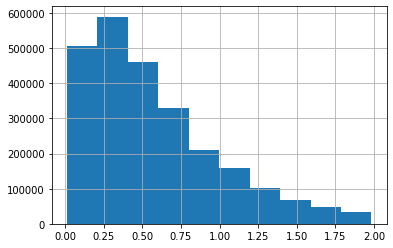

In [36]:
dock_station_train_merged.loc[dock_station_train_merged['Percent_usage']<2]['Percent_usage'].hist()

In [37]:
dock_station_train_merged.drop(['median','capacity'],axis=1,inplace=True)

In [38]:
dock_station_train_merged.to_csv('train.csv')

### Merge Dockstation with test dataset

In [39]:
dockdf_merged_test = test_df_weather.merge(dockdf,how='left',on=['start_station_name','start_date'])
dock_station_test_merged = dockdf_merged_test.merge(dock_station,how='left',on=['start_station_name'])
print(dock_station_test_merged.tot_docks.isna().sum())
mask1 = (dock_station_test_merged['tot_docks']<=10) & (dock_station_test_merged['capacity']>20)
dock_station_test_merged.tot_docks[mask1] = np.nan
print(dock_station_test_merged.tot_docks.isna().sum())
dock_station_test_merged['tot_docks'] = dock_station_test_merged['tot_docks'].fillna(dock_station_test_merged['capacity'])
dock_station_test_merged.tot_docks.isna().sum()

166923
167386


25753

In [40]:
dock_station_test_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity
0,1728,2017-01-16 14:07:10,2017-01-16 14:35:59,301.0,E 2 St & Avenue B,40.722174,-73.983688,279.0,Peck Slip & Front St,40.707873,-74.001670,25015,2017-01-16,2017,1,16,14,1,1,1,2017-01-16,14,8.0,4.0,12.0,6.0,4.0,10.0,1.939856,23387,713.239278,1.343726,134.0,680.604478,1.148099,8.0,761.000000,1.106751,4.70,0.00,0.0,0.0,43,30,0.0,0.0,0.0,0.0,0.0,0.0,36.5,0,0,37.0,37.0,58.0
1,128,2017-01-17 17:25:50,2017-01-17 17:27:58,350.0,Clinton St & Grand St,40.715595,-73.987030,291.0,Madison St & Montgomery St,40.713126,-73.984844,26838,2017-01-17,2017,1,17,17,2,1,0,2017-01-17,17,1.0,5.0,6.0,1.0,8.0,9.0,0.286199,18190,661.653161,1.369798,131.0,526.954198,0.883908,1.0,128.000000,0.286199,4.92,0.35,0.0,0.0,42,38,1.0,0.0,0.0,0.0,0.0,1.0,40.0,1,0,28.0,28.0,28.0
2,352,2017-01-20 15:30:57,2017-01-20 15:36:49,435.0,W 21 St & 6 Ave,40.741740,-73.994156,509.0,9 Ave & W 22 St,40.745497,-74.001971,16996,2017-01-20,2017,1,20,15,5,1,0,2017-01-20,15,16.0,8.0,24.0,4.0,25.0,29.0,0.673514,25833,683.189680,1.359980,375.0,629.480000,1.101935,16.0,480.500000,0.987935,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,47.0,47.0,50.0
3,367,2017-01-31 08:53:43,2017-01-31 08:59:51,517.0,Pershing Square South,40.751581,-73.977910,523.0,W 38 St & 8 Ave,40.754666,-73.991382,14647,2017-01-31,2017,1,31,8,2,1,0,2017-01-31,8,23.0,26.0,49.0,16.0,17.0,33.0,0.926849,24545,645.918150,1.328383,591.0,677.368866,1.639718,23.0,673.521739,1.605749,4.03,0.06,1.0,0.0,34,26,1.0,1.0,0.0,0.0,0.0,1.0,30.0,1,1,59.0,59.0,69.0
4,419,2017-01-04 14:07:41,2017-01-04 14:14:40,3120.0,Center Blvd & Borden Ave,40.741610,-73.960440,3125.0,45 Rd & 11 St,40.747086,-73.949772,20232,2017-01-04,2017,1,4,14,3,1,0,2017-01-04,14,2.0,1.0,3.0,0.0,4.0,4.0,0.943220,33455,714.582663,1.407101,15.0,918.800000,1.294628,2.0,301.000000,0.687617,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,20.0,20.0,NaN


In [41]:
# Impute missing values in tot_docks for all stations
missing = list(dock_station_test_merged.loc[dock_station_test_merged.tot_docks.isna()]['start_station_ID'].unique())
for i in missing:
    missingrows = len(dock_station_test_merged.loc[(dock_station_test_merged['start_station_ID']==i)\
                                                    & (dock_station_test_merged['tot_docks'].isna())])
    if len(dock_station_test_merged.loc[(dock_station_test_merged['start_station_ID']==i)]) != missingrows:
        mask =  (dock_station_test_merged['start_station_ID']==i) & (dock_station_test_merged['tot_docks'].isna())
        med = dock_station_test_merged.loc[(dock_station_test_merged['start_station_ID']==i)]['tot_docks'].median()
        dock_station_test_merged.loc[mask,'tot_docks']=dock_station_test_merged.loc[mask,'tot_docks'].fillna(med) 
dock_station_test_merged.loc[dock_station_test_merged.tot_docks.isna()]['start_station_ID'].nunique()

48

In [42]:
# Name is not matching or station is obselete 
missing1 = list(dock_station_test_merged.loc[dock_station_test_merged.tot_docks.isna()]['start_station_ID'].unique())
dock_station_test_merged.loc[dock_station_test_merged['start_station_ID'].isin(missing1)]

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity
1428,449,2017-01-20 19:09:11,2017-01-20 19:16:41,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,393.0,E 5 St & Avenue C,40.722992,-73.979955,25159,2017-01-20,2017,1,20,19,5,1,0,2017-01-20,19,4.0,5.0,9.0,3.0,4.0,7.0,0.611346,25833,683.189680,1.359980,67.0,602.462687,1.199091,4.0,580.500000,1.218672,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,NaN,NaN,NaN
1861,904,2017-01-26 09:47:28,2017-01-26 10:02:32,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,315.0,South St & Gouverneur Ln,40.703554,-74.006702,18503,2017-01-26,2017,1,26,9,4,1,0,2017-01-26,10,3.0,0.0,3.0,1.0,2.0,3.0,2.364366,32084,685.643872,1.364001,128.0,678.679688,1.379311,3.0,486.666667,1.212054,6.71,0.02,0.0,0.0,56,43,0.0,0.0,0.0,0.0,0.0,0.0,49.5,1,0,NaN,NaN,NaN
2505,67,2017-01-20 15:33:15,2017-01-20 15:34:23,3036.0,8D OPS 01,40.517975,-74.031372,3036.0,8D OPS 01,40.517975,-74.031372,21928,2017-01-20,2017,1,20,15,5,1,0,2017-01-20,15,1.0,1.0,2.0,1.0,1.0,2.0,0.138764,25833,683.189680,1.359980,1.0,67.000000,0.138764,1.0,67.000000,0.138764,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,NaN,NaN,NaN
2510,999,2017-01-27 08:57:14,2017-01-27 09:13:54,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,304.0,Broadway & Battery Pl,40.704633,-74.013617,25923,2017-01-27,2017,1,27,8,5,1,0,2017-01-27,9,14.0,2.0,16.0,3.0,23.0,26.0,2.656360,31465,677.758303,1.340342,162.0,774.932099,1.766274,14.0,722.000000,1.953944,8.95,0.00,0.0,0.0,43,36,0.0,0.0,0.0,0.0,0.0,0.0,39.5,0,0,NaN,NaN,NaN
3145,834,2017-01-30 17:16:09,2017-01-30 17:30:04,3265.0,E 2 St & 2 Ave E,40.724563,-73.989444,284.0,Greenwich Ave & 8 Ave,40.739017,-74.002638,26434,2017-01-30,2017,1,30,17,1,1,0,2017-01-30,17,4.0,5.0,9.0,13.0,28.0,41.0,1.696563,29027,666.373549,1.342076,79.0,1320.898734,1.085237,4.0,689.250000,1.245222,6.26,0.00,0.0,0.0,37,30,0.0,0.0,0.0,0.0,0.0,0.0,33.5,0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2493721,369,2019-12-09 18:30:32.633,2019-12-09 18:36:42.148,3788.0,E 12 St & 4 Av,40.732690,-73.989740,3718.0,E 11 St & Avenue B,40.727464,-73.979504,34048,2019-12-09,2019,12,9,18,1,1,0,2019-12-09,18,5.0,1.0,6.0,5.0,4.0,9.0,0.903078,14521,674.950279,1.196175,204.0,546.318627,1.037512,5.0,766.000000,1.167822,4.47,1.57,0.0,0.0,55,42,1.0,0.0,0.0,0.0,0.0,0.0,48.5,1,0,NaN,NaN,NaN
2493833,459,2019-12-12 16:44:25.131,2019-12-12 16:52:04.162,3793.0,Stuyvesant Walk & 1 Av Loop,40.732340,-73.978984,496.0,E 16 St & 5 Ave,40.737262,-73.992390,39649,2019-12-12,2019,12,12,16,4,1,0,2019-12-12,16,2.0,2.0,4.0,11.0,11.0,22.0,1.050133,43932,684.607006,1.298297,18.0,702.277778,0.973284,2.0,351.500000,0.800736,4.70,0.00,0.0,0.0,36,26,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0,0,NaN,NaN,NaN
2493846,375,2019-12-03 20:27:55.914,2019-12-03 20:34:11.092,3810.0,Central Park West & W 82 St,40.782593,-73.971211,3328.0,W 100 St & Manhattan Ave,40.795000,-73.964500,40930,2019-12-03,2019,12,3,20,2,1,0,2019-12-03,20,1.0,3.0,4.0,1.0,3.0,4.0,1.211766,38464,681.709599,1.297637,28.0,1052.785714,1.537293,1.0,375.000000,1.211766,7.16,0.02,0.3,1.2,36,30,1.0,0.0,0.0,0.0,0.0

In [43]:
# Sanity check and overwrite errors in dock capacity 
mask = dock_station_test_merged['tot_docks']!=0 
dock_station_test_merged = dock_station_test_merged[mask]# remove stations that have 0 tot_docks

In [44]:
dock_station_test_merged.head()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity
0,1728,2017-01-16 14:07:10,2017-01-16 14:35:59,301.0,E 2 St & Avenue B,40.722174,-73.983688,279.0,Peck Slip & Front St,40.707873,-74.001670,25015,2017-01-16,2017,1,16,14,1,1,1,2017-01-16,14,8.0,4.0,12.0,6.0,4.0,10.0,1.939856,23387,713.239278,1.343726,134.0,680.604478,1.148099,8.0,761.000000,1.106751,4.70,0.00,0.0,0.0,43,30,0.0,0.0,0.0,0.0,0.0,0.0,36.5,0,0,37.0,37.0,58.0
1,128,2017-01-17 17:25:50,2017-01-17 17:27:58,350.0,Clinton St & Grand St,40.715595,-73.987030,291.0,Madison St & Montgomery St,40.713126,-73.984844,26838,2017-01-17,2017,1,17,17,2,1,0,2017-01-17,17,1.0,5.0,6.0,1.0,8.0,9.0,0.286199,18190,661.653161,1.369798,131.0,526.954198,0.883908,1.0,128.000000,0.286199,4.92,0.35,0.0,0.0,42,38,1.0,0.0,0.0,0.0,0.0,1.0,40.0,1,0,28.0,28.0,28.0
2,352,2017-01-20 15:30:57,2017-01-20 15:36:49,435.0,W 21 St & 6 Ave,40.741740,-73.994156,509.0,9 Ave & W 22 St,40.745497,-74.001971,16996,2017-01-20,2017,1,20,15,5,1,0,2017-01-20,15,16.0,8.0,24.0,4.0,25.0,29.0,0.673514,25833,683.189680,1.359980,375.0,629.480000,1.101935,16.0,480.500000,0.987935,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,47.0,47.0,50.0
3,367,2017-01-31 08:53:43,2017-01-31 08:59:51,517.0,Pershing Square South,40.751581,-73.977910,523.0,W 38 St & 8 Ave,40.754666,-73.991382,14647,2017-01-31,2017,1,31,8,2,1,0,2017-01-31,8,23.0,26.0,49.0,16.0,17.0,33.0,0.926849,24545,645.918150,1.328383,591.0,677.368866,1.639718,23.0,673.521739,1.605749,4.03,0.06,1.0,0.0,34,26,1.0,1.0,0.0,0.0,0.0,1.0,30.0,1,1,59.0,59.0,69.0
4,419,2017-01-04 14:07:41,2017-01-04 14:14:40,3120.0,Center Blvd & Borden Ave,40.741610,-73.960440,3125.0,45 Rd & 11 St,40.747086,-73.949772,20232,2017-01-04,2017,1,4,14,3,1,0,2017-01-04,14,2.0,1.0,3.0,0.0,4.0,4.0,0.943220,33455,714.582663,1.407101,15.0,918.800000,1.294628,2.0,301.000000,0.687617,8.05,0.00,0.0,0.0,52,34,1.0,0.0,0.0,0.0,0.0,1.0,43.0,0,0,20.0,20.0,NaN


In [45]:
dock_station_test_merged['Percent_usage'] = dock_station_test_merged['start_station_total_counts']/dock_station_test_merged['tot_docks']
dock_station_test_merged[['Percent_usage']].describe()   

,Percent_usage
count,2.472922e+06
mean,6.639017e-01
std,6.526698e-01
min,1.470588e-02
25%,2.564103e-01
50%,4.857143e-01
75%,8.536585e-01
max,1.433333e+01


In [46]:
dock_station_test_merged.loc[dock_station_test_merged['Percent_usage']>10]#['start_station_ID'].unique()

,trip_duration,starttime,stoptime,start_station_ID,start_station_name,start_station_latitude,start_station_longitude,end_station_ID,end_station_name,end_station_latitude,end_station_longitude,bike_ID,start_date,start_year,start_month,start_day,start_hour,start_dayofweek,Isweekday,holidays,stop_date,stop_hour,start_station_checkout_counts,start_station_checkin_counts,start_station_total_counts,end_station_checkout_counts,end_station_checkin_counts,end_station_total_counts,distance,trip_per_day,daily_avg_trip_duration,daily_avg_distance,trip_per_hour,hourly_avg_trip_duration,hourly_avg_distance,trip_per_hour_eachday,hourly_avg_trip_duration_eachday,hourly_avg_distance_eachday,AWND,PRCP,SNOW,SNWD,TMAX,TMIN,Fog,Heavy_Fog,Thunder,Hail,Glaze,Haze,TAVG,HasPRCP,HasSNOW,tot_docks,median,capacity,Percent_usage
964,998,2017-01-12 08:11:37,2017-01-12 08:28:15,3230.0,Penn Station Valet,40.751284,-73.996924,281.0,Grand Army Plaza & Central Park S,40.764397,-73.973715,25775,2017-01-12,2017,1,12,8,4,1,0,2017-01-12,8,84.0,7.0,91.0,6.0,33.0,39.0,2.134952,39012,752.152517,1.473844,1118.0,765.279070,1.576902,84.0,872.952381,1.700020,7.61,0.05,0.0,0.0,66,47,1.0,0.0,0.0,0.0,0.0,0.0,56.5,1,0,7.0,7.0,NaN,13.000000
1538,364,2017-01-25 08:30:44,2017-01-25 08:36:48,3230.0,Penn Station Valet,40.751284,-73.996924,515.0,W 43 St & 10 Ave,40.760094,-73.994618,17632,2017-01-25,2017,1,25,8,3,1,0,2017-01-25,8,73.0,6.0,79.0,7.0,4.0,11.0,0.730163,36154,726.042015,1.407985,1118.0,765.279070,1.576902,73.0,807.698630,1.594149,6.71,0.00,0.0,0.0,51,36,0.0,0.0,0.0,0.0,0.0,0.0,43.5,0,0,7.0,7.0,NaN,11.285714
2150,971,2017-01-20 08:49:44,2017-01-20 09:05:55,3230.0,Penn Station Valet,40.751284,-73.996924,281.0,Grand Army Plaza & Central Park S,40.764397,-73.973715,26954,2017-01-20,2017,1,20,8,5,1,0,2017-01-20,9,82.0,7.0,89.0,5.0,15.0,20.0,2.134952,25833,683.189680,1.359980,1118.0,765.279070,1.576902,82.0,744.012195,1.632753,4.03,0.10,0.0,0.0,45,40,1.0,0.0,0.0,0.0,0.0,0.0,42.5,1,0,7.0,7.0,NaN,12.714286
2626,1810,2017-01-30 08:24:27,2017-01-30 08:54:37,3230.0,Penn Station Valet,40.751284,-73.996924,304.0,Broadway & Battery Pl,40.704633,-74.013617,20615,2017-01-30,2017,1,30,8,1,1,0,2017-01-30,8,75.0,11.0,86.0,2.0,34.0,36.0,4.103576,29027,666.373549,1.342076,1118.0,765.279070,1.576902,75.0,801.280000,1.669897,6.26,0.00,0.0,0.0,37,30,0.0,0.0,0.0,0.0,0.0,0.0,33.5,0,0,7.0,7.0,NaN,12.285714
3684,277,2017-01-12 08:13:02,2017-01-12 08:17:39,3230.0,Penn Station Valet,40.751284,-73.996924,458.0,11 Ave & W 27 St,40.751396,-74.005226,15563,2017-01-12,2017,1,12,8,4,1,0,2017-01-12,8,84.0,7.0,91.0,8.0,21.0,29.0,0.447737,39012,752.152517,1.473844,1118.0,765.279070,1.576902,84.0,872.952381,1.700020,7.61,0.05,0.0,0.0,66,47,1.0,0.0,0.0,0.0,0.0,0.0,56.5,1,0,7.0,7.0,NaN,13.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2278254,1510,2019-09-23 17:24:12.186,2019-09-23 17:49:22.788,3255.0,8 Ave & W 31 St,40.750585,-73.994685,496.0,E 16 St & 5 Ave,40.737262,-73.992390,35298,2019-09-23,2019,9,23,17,1,1,0,2019-09-23,17,40.0,168.0,208.0,64.0,38.0,102.0,1.040963,83343,873.679217,1.505077,863.0,952.584009,1.680651,40.0,984.900000,1.576878,5.37,0.11,0.0,0.0,89,70,1.0,0.0,0.0,0.0,0.0,0.0,79.5,1,0,19.0,19.0,19.0,10.947368
2308531,845,2019-10-24 17:35:08.959,2019-10-24 17:49:14.660,3255.0,8 Ave & W 31 St,40.750585,-73.994685,3443.0,W 52 St & 6 Ave,40.761330,-73.979820,41074,2019-10-24,2019,10,24,17,4,1,0,2019-10-24,17,34.0,175.0,209.0,83.0,12.0,95.0,1.529204,80921,832.606258,1.497998,762.0,913.069554,1.633339,34.0,871.411765,1.674527,3.13,0.00,0.0,0.0,67,50,0.0,0.0,0.0,0.0,0.0,0.0,58.5,0,0,19.0,19.0,19.0,11.000000
2343225,144,2019-10-21 17:31:30.037,2019-10-21 17:33:54.373,3255.0,8 Ave & W 31 St,40.750585,-73.994685,3259.0,9 Ave & W 28 St,40.749370,-73.999234,25149,2019-10-21,2019,10,21,17,1,1,0,2019-10-21,17,34.0,159.0

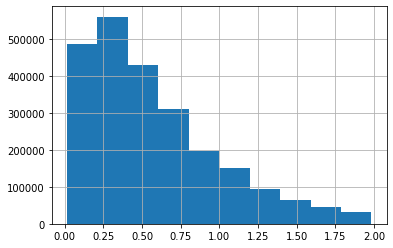

In [47]:
dock_station_test_merged.loc[dock_station_test_merged['Percent_usage']<2]['Percent_usage'].hist()

In [48]:
dock_station_test_merged.drop(['median','capacity'],axis=1,inplace=True)

In [49]:
dock_station_test_merged.to_csv('test.csv')